In [217]:
import pandas as pd
import numpy as np
import re
import pickle
import string
from matplotlib import pyplot as plt

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import Recall
from tensorflow.keras.preprocessing.text import Tokenizer
import tensorflow

import re
from sklearn.model_selection import train_test_split
import seaborn as sns

In [218]:
def plot_scores(train) :
    accuracy = train.history['accuracy']
    val_accuracy = train.history['val_accuracy']
    epochs = range(len(accuracy))
    plt.plot(epochs, accuracy, 'b', label='Score apprentissage')
    plt.plot(epochs, val_accuracy, 'r', label='Score validation')
    plt.title('Scores')
    plt.legend()
    plt.show()

## Analyse

In [219]:
df = pd.read_csv('./generated-data/generated.csv', ';')
df = df.sample(frac=1).reset_index(drop=True)

C:\Users\sacha\AppData\Local\Temp\ipykernel_13156\1254728695.py:1: FutureWarning: In a future version of pandas all arguments of read_csv except for the argument 'filepath_or_buffer' will be keyword-only.
  df = pd.read_csv('./generated-data/generated.csv', ';')


In [220]:
df.head()

,label,text
0,other,ou 8905
1,contact,Radomír Kratochvíl Th.D. 070-7937-4345 tel Ali...
2,contact,Sou#enir lit. tel +33 4(84 36 96 94 Jiří Kopec...
3,address,9& cour Marguerite Deschamps Wtst Ca/lstad
4,code,80288480


In [221]:
df.label.value_counts()

other      3716
code       3716
contact    3715
address    3715
Name: label, dtype: int64

In [222]:
df['rate_int'] = df.text.str.count(r'\d') / df.text.str.count(r'.')
df.head()

,label,text,rate_int
0,other,ou 8905,0.571429
1,contact,Radomír Kratochvíl Th.D. 070-7937-4345 tel Ali...,0.157143
2,contact,Sou#enir lit. tel +33 4(84 36 96 94 Jiří Kopec...,0.196429
3,address,9& cour Marguerite Deschamps Wtst Ca/lstad,0.023810
4,code,80288480,1.000000


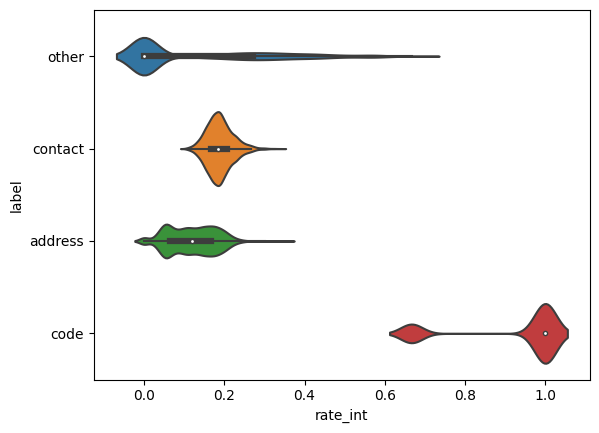

In [223]:
sns.violinplot(x='rate_int', y='label', data=df)
plt.show()

In [224]:
len(df.text)

14862

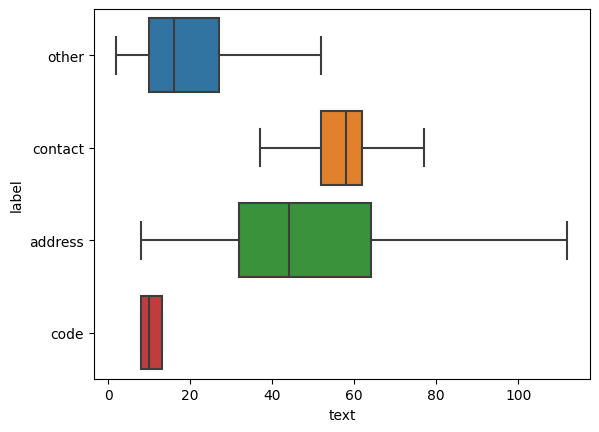

In [225]:
from numpy import outer

sns.boxplot(x=df.text.str.len(), y='label', data=df, showfliers=False)
plt.show()

## Preprocessing

In [226]:
X = df
y = df.label

In [227]:
X_ =  X.copy()

str_to_replace = ',;:!?./§&~"#([-|`_\\^@)]=}²<>%$£¤*+'

translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
translator2 = str.maketrans(str_to_replace, ' '*len(str_to_replace)) 

X_['encoded_text'] = X_['text'].apply(lambda x: re.sub(r"\d{6,}", "$" , x))  
X_['encoded_text'] = X_['encoded_text'].apply(lambda x: re.sub(r"\d{4,6}", "####" , x))  
X_['encoded_text'] = X_['encoded_text'].apply(lambda x: re.sub(r"\d{3,4}", "###" , x)) 
X_['encoded_text'] = X_['encoded_text'].apply(lambda x: re.sub(r"\d{2,3}", "##" , x)) 
X_['encoded_text'] = X_['encoded_text'].apply(lambda x: re.sub(r"\d", "#" , x))
X_['encoded_text'] = X_['encoded_text'].apply(lambda x: re.sub(r"(\b\S+\b)", r"@\1" , x))
X_['encoded_text'] = X_['encoded_text'].apply(lambda x: re.sub(r' ', '', x))

top_words = 2000
tokenizer = Tokenizer(num_words=top_words, char_level=True)
tokenizer.fit_on_texts(X_['encoded_text'] )

with open('tokenizer.pickle', 'wb') as f:
    pickle.dump(tokenizer, f)

In [228]:
X_.head(20)

,label,text,rate_int,encoded_text
0,other,ou 8905,0.571429,@ou####
1,contact,Radomír Kratochvíl Th.D. 070-7937-4345 tel Ali...,0.157143,@Radomír@Kratochvíl@Th.D.###-####-####@tel@Ali...
2,contact,Sou#enir lit. tel +33 4(84 36 96 94 Jiří Kopec...,0.196429,@Sou#enir@lit.@tel+###(########@Jiří@Kopecký@c...
3,address,9& cour Marguerite Deschamps Wtst Ca/lstad,0.023810,#&@cour@Marguerite@Deschamps@Wtst@Ca/lstad
4,code,80288480,1.000000,$
5,contact,Possimus suscipit. Leif Myhre mobile 035687186...,0.180000,@Possimus@suscipit.@Leif@Myhre@mobile$@tel
6,contact,Cristiano Magalhães 投资完全重要这个的话不同推荐一样在线. 186152...,0.174603,@Cristiano@Magalhães@投资完全重要这个的话不同推荐一样在线.$@info...
7,address,"869 Steiner Haven, Apt. 134, 4031, Giuseppesta...",0.147059,"###@Steiner@Haven,@Apt.###,####,@Giuseppestad,..."
8,address,59 way Brigitte Prévost Jenniferfurt,0.055556,##@way@Brigitte@Prévost@Jenniferfurt
9,address,580 place Mrs Lorraine Ford 38794 Marchal,0.195122,###@place@Mrs@Lorraine@Ford####@Marchal


In [229]:
def preprocessing(X,y = None,max_words_c = 200, max_words_w = 100):
    with open('./tokenizer.pickle', 'rb') as handle:
        tokenizer = pickle.load(handle)

    str_to_replace = ',;:!?./§&~"#([-|`_\\^@)]=}²<>%$£¤*+'

    translator = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    translator2 = str.maketrans(str_to_replace, ' '*len(str_to_replace)) 

    X_ = []
    for i, sentence in enumerate(X):
        tmp_sentence = sentence.lower()
        tmp_sentence = tmp_sentence.replace('\n', '')
        tmp_sentence = tmp_sentence.translate(translator)
        tmp_sentence = tmp_sentence.translate(translator2)
        
        tmp_sentence = re.sub(r"\d{6,}", "$" , tmp_sentence)
        tmp_sentence = re.sub(r"\d{4,6}", "####" , tmp_sentence)
        tmp_sentence = re.sub(r"\d{3,4}", "###" , tmp_sentence)
        tmp_sentence = re.sub(r"\d{2,3}", "##" , tmp_sentence)
        tmp_sentence = re.sub(r"\d", "#" , tmp_sentence)
        tmp_sentence = re.sub(r"(\b\S+\b)", r"@\1" , tmp_sentence)
        tmp_sentence = re.sub(r' ', '', tmp_sentence)
        X_.append(tmp_sentence)
    X = X_.copy()

    X_clvl = tokenizer.texts_to_sequences(X)
    X_clvl = sequence.pad_sequences(X_clvl, maxlen=max_words_c, padding='post')

    if y is not None:
        y = y.map({'address': 0,'code': 1, 'contact': 2, 'other': 3})
        y = to_categorical(y)
        return X_clvl , y
    else:
        return X_clvl

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.3, shuffle=False)

In [231]:
X_train_e ,y_train = preprocessing(X_train.text,y_train)
X_test_e ,y_test = preprocessing(X_test.text,y_test)

In [232]:
X_train.head()

,label,text,rate_int
0,other,ou 8905,0.571429
1,contact,Radomír Kratochvíl Th.D. 070-7937-4345 tel Ali...,0.157143
2,contact,Sou#enir lit. tel +33 4(84 36 96 94 Jiří Kopec...,0.196429
3,address,9& cour Marguerite Deschamps Wtst Ca/lstad,0.023810
4,code,80288480,1.000000


# Model

In [233]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import LSTM, Activation, Dense, Dropout, Input, Embedding, Conv1D, MaxPool1D, Flatten, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.utils import to_categorical, plot_model
from tensorflow.keras.callbacks import EarlyStopping

In [234]:
#Char lvl
input = Input(shape=(200,))
embed = Embedding(1000, 200, input_length=200)(input)

# First Branch
conv1 = Conv1D(128,1,activation='relu', padding="same")(embed)
drop1 = Dropout(0.2)(conv1)
maxpool1 = MaxPool1D()(drop1)

convA = Conv1D(128,3,activation='relu', padding="same")(embed)
dropA = Dropout(0.2)(convA)
maxpoolA = MaxPool1D()(dropA)

conv2 = Conv1D(128,5,activation='relu', padding="same")(embed)
drop2 = Dropout(0.2)(conv2)
maxpool2 = MaxPool1D()(drop2)

conv6 = Conv1D(128,7,activation='relu', padding="same")(embed)
drop6 = Dropout(0.2)(conv6)
maxpool6 = MaxPool1D()(drop6)

conv7 = Conv1D(128,10,activation='relu', padding="same")(embed)
drop7 = Dropout(0.2)(conv7)
maxpool7 = MaxPool1D()(drop7)

concat = Concatenate()([maxpool1, maxpoolA, maxpool2, maxpool6, maxpool7])

conv3 = Conv1D(128, 1, activation='relu')(concat)
drop3 = MaxPool1D()(conv3)
conv4 = Conv1D(64, 3, activation='relu')(drop3)
conv5 = Conv1D(32, 3, activation='relu')(conv4)

flatten = Flatten()(conv5)

dense = Dense(4, activation='softmax')(flatten)

model = Model(input, dense)
opt = Adam(learning_rate=0.001)

model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', Recall()])

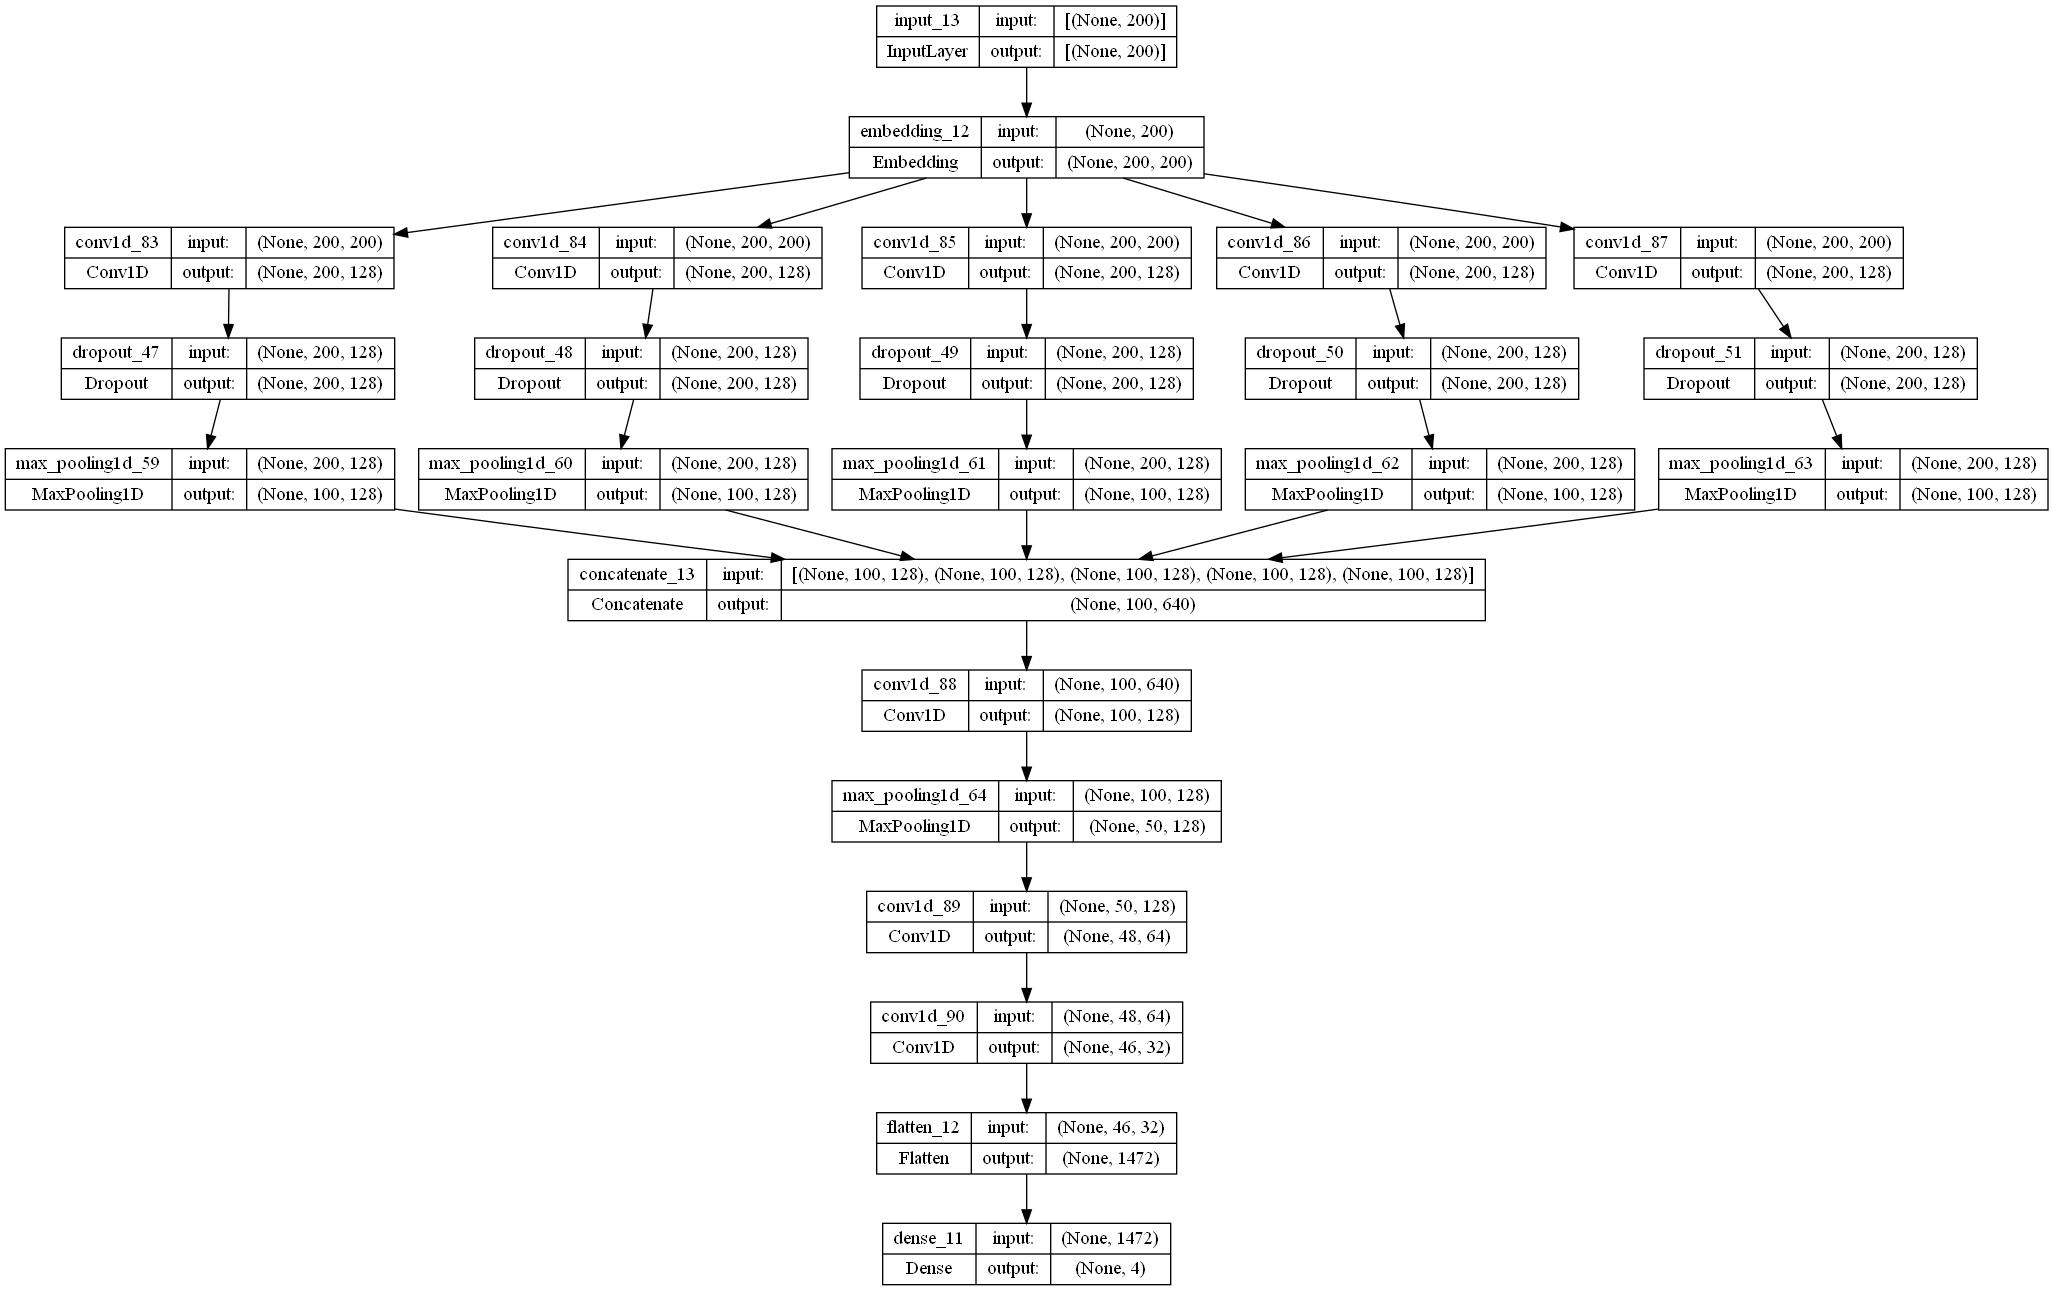

In [235]:
plot_model(model, show_shapes=True)

In [236]:
#es = EarlyStopping("val_loss", 0.001, 70, mode='min', restore_best_weights=True)

train = model.fit(X_train_e, y_train, validation_data=(X_test_e, y_test), 
    epochs=50, batch_size=128, verbose=2)

Epoch 1/50
82/82 - 11s - loss: 0.5824 - accuracy: 0.7500 - recall_11: 0.6798 - val_loss: 0.3075 - val_accuracy: 0.8838 - val_recall_11: 0.8769 - 11s/epoch - 129ms/step
Epoch 2/50
82/82 - 5s - loss: 0.0919 - accuracy: 0.9712 - recall_11: 0.9693 - val_loss: 0.0450 - val_accuracy: 0.9892 - val_recall_11: 0.9886 - 5s/epoch - 59ms/step
Epoch 3/50
82/82 - 5s - loss: 0.0275 - accuracy: 0.9932 - recall_11: 0.9930 - val_loss: 0.0462 - val_accuracy: 0.9901 - val_recall_11: 0.9901 - 5s/epoch - 56ms/step
Epoch 4/50
82/82 - 4s - loss: 0.0158 - accuracy: 0.9957 - recall_11: 0.9957 - val_loss: 0.0273 - val_accuracy: 0.9935 - val_recall_11: 0.9935 - 4s/epoch - 45ms/step
Epoch 5/50
82/82 - 4s - loss: 0.0147 - accuracy: 0.9955 - recall_11: 0.9954 - val_loss: 0.0333 - val_accuracy: 0.9906 - val_recall_11: 0.9899 - 4s/epoch - 47ms/step
Epoch 6/50
82/82 - 4s - loss: 0.0078 - accuracy: 0.9971 - recall_11: 0.9971 - val_loss: 0.0240 - val_accuracy: 0.9942 - val_recall_11: 0.9939 - 4s/epoch - 45ms/step
Epoch 7

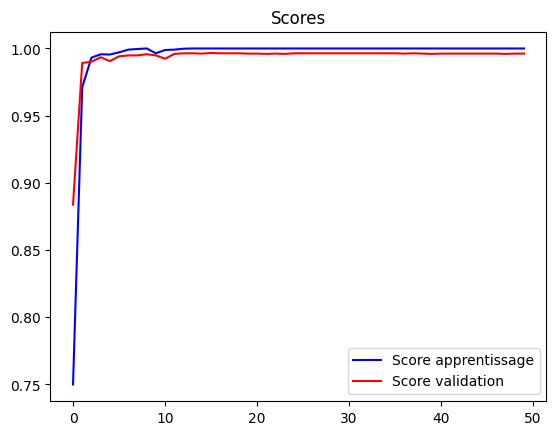

In [237]:
plot_scores(train)

In [238]:
model.save('weights/15_addr_identification.h5')

In [239]:
def ratio_int(lst):
    r_ratio = [0 for i in range(len(lst))]

    for idx, stc in enumerate(lst):
        r_ratio[idx] = (sum(int(c.isdigit()) for c in stc)/len(stc))

    return r_ratio
        

In [241]:
r = [
    'piece 1 of 1',
    '34 rue de cherbourg',
    'weight (lb.) 99',
    '484121025410',
    '75541 Paris 13e rue des moustaches',
    'ship to/poe',
    'weight (ib.) 99',
    'cube (ft.) a',
    'tac/typeservice/carrier ups',
    'date shipped o-jan-17',
    ' from ilwh2 cornell aerospace 1815 roberts drive, unit 2 saddle river, utah 84108',
    'ship to/poe',
    'staging facility brentwood lloyd defense technologies 1815 route 35 bldg 2,joint base lakehurst, new jersey 08773 limited status'
]

r_c = preprocessing(r)

model.predict(r_c)

1/1 [==============================] - 0s 50ms/step


array([[3.6751255e-09, 2.9614667e-17, 1.3365737e-08, 1.0000000e+00],
       [1.0000000e+00, 4.0753264e-08, 5.0379212e-10, 1.3420429e-08],
       [5.7905769e-10, 1.1930944e-18, 4.0329500e-09, 1.0000000e+00],
       [1.7526834e-06, 9.9999762e-01, 3.5066033e-11, 5.7813628e-07],
       [1.0000000e+00, 1.9598916e-16, 2.2259070e-09, 2.1513686e-18],
       [1.3136656e-07, 6.5915892e-24, 1.8813873e-07, 9.9999964e-01],
       [5.5040155e-09, 3.0124622e-20, 3.0513473e-08, 1.0000000e+00],
       [7.7054858e-07, 1.1628095e-17, 5.7001301e-08, 9.9999928e-01],
       [1.7899005e-07, 1.2175525e-21, 4.1335673e-09, 9.9999976e-01],
       [3.7742620e-08, 2.8677431e-20, 2.4346898e-09, 1.0000000e+00],
       [1.0000000e+00, 2.3804092e-28, 2.1129628e-18, 5.1089965e-25],
       [1.3136656e-07, 6.5915892e-24, 1.8813873e-07, 9.9999964e-01],
       [1.0000000e+00, 1.0272583e-23, 4.8895772e-13, 5.3393805e-08]],
      dtype=float32)

In [297]:
#Char lvl

input = Input(shape=(200,))
embed = Embedding(500, 200, input_length=200)(input)
#word lvl
input2 = Input(shape=(100,))
embed2 = Embedding(10000, 200, input_length=100)(input2)

maxpool1 = MaxPool1D()(embed)

concat = Concatenate()([maxpool1, embed2])

conv9 = Conv1D(256, 1, activation='relu')(concat)
drop = Dropout(0.3)(conv9)
maxpool = MaxPool1D()(drop)
conv10 = Conv1D(128, 3, activation='relu')(maxpool)
drop2 = Dropout(0.3)(conv10)
maxpool2 = MaxPool1D()(drop2)
conv11 = Conv1D(128, 3, activation='relu')(maxpool2)

flatten3 = Flatten()(conv11)

dense = Dense(4, activation='softmax')(flatten3)

model2 = Model([input,input2], dense)
opt = Adam(learning_rate=0.001)

model2.compile(loss='categorical_crossentropy', optimizer=opt, metrics=['accuracy', Recall()])

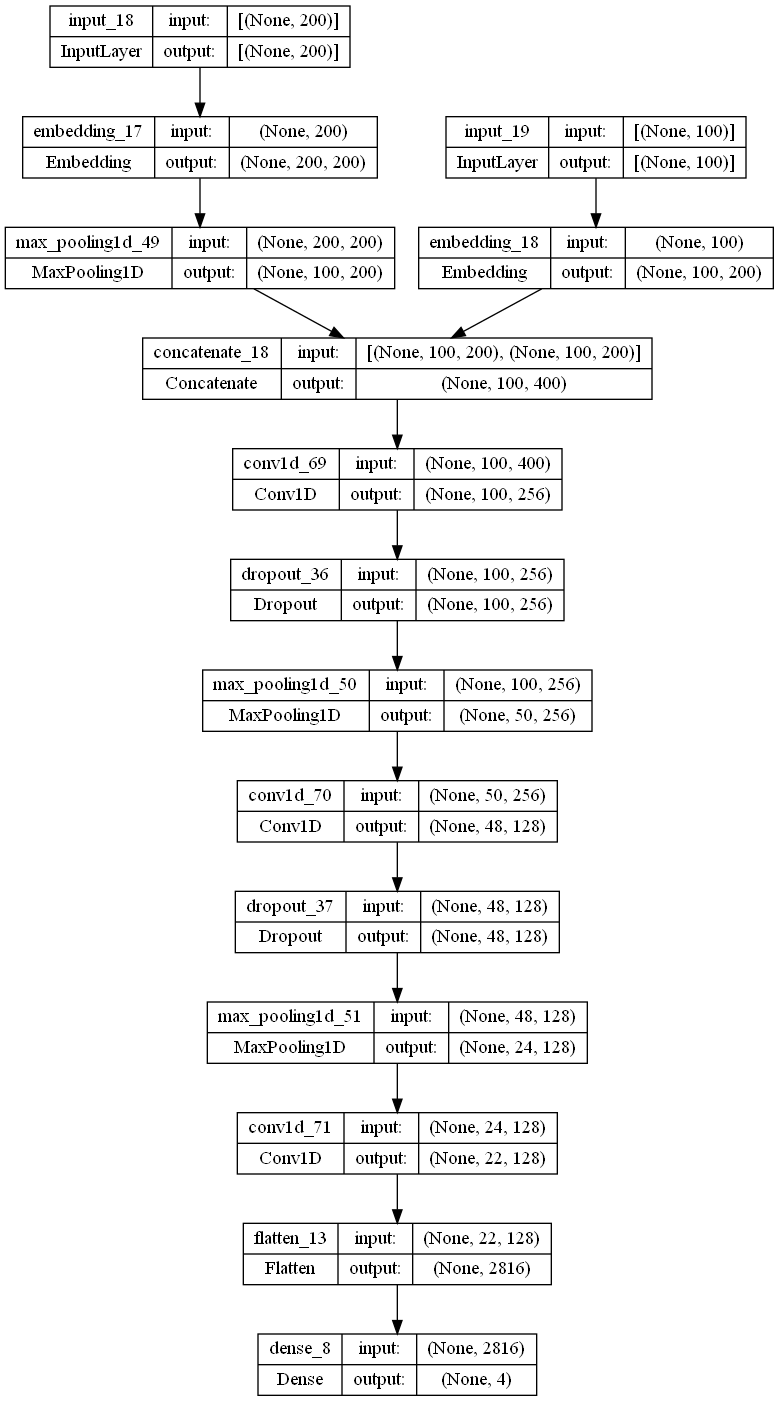

In [298]:
plot_model(model2, show_shapes=True)

In [299]:
train = model2.fit([X_train_c, X_train_w], y_train, validation_data=([X_test_c, X_test_w], y_test), 
    epochs=100, batch_size=128, verbose=2)

Epoch 1/100
75/75 - 4s - loss: 0.6085 - accuracy: 0.7437 - recall_8: 0.6578 - val_loss: 0.2387 - val_accuracy: 0.9288 - val_recall_8: 0.9022 - 4s/epoch - 51ms/step
Epoch 2/100
75/75 - 2s - loss: 0.1184 - accuracy: 0.9578 - recall_8: 0.9556 - val_loss: 0.0718 - val_accuracy: 0.9829 - val_recall_8: 0.9819 - 2s/epoch - 23ms/step
Epoch 3/100
75/75 - 2s - loss: 0.0550 - accuracy: 0.9810 - recall_8: 0.9808 - val_loss: 0.0678 - val_accuracy: 0.9817 - val_recall_8: 0.9802 - 2s/epoch - 21ms/step
Epoch 4/100
75/75 - 2s - loss: 0.0355 - accuracy: 0.9880 - recall_8: 0.9880 - val_loss: 0.0356 - val_accuracy: 0.9900 - val_recall_8: 0.9900 - 2s/epoch - 26ms/step
Epoch 5/100
75/75 - 2s - loss: 0.0303 - accuracy: 0.9902 - recall_8: 0.9902 - val_loss: 0.0321 - val_accuracy: 0.9885 - val_recall_8: 0.9885 - 2s/epoch - 21ms/step
Epoch 6/100
75/75 - 2s - loss: 0.0223 - accuracy: 0.9919 - recall_8: 0.9919 - val_loss: 0.0279 - val_accuracy: 0.9892 - val_recall_8: 0.9892 - 2s/epoch - 28ms/step
Epoch 7/100
75/7

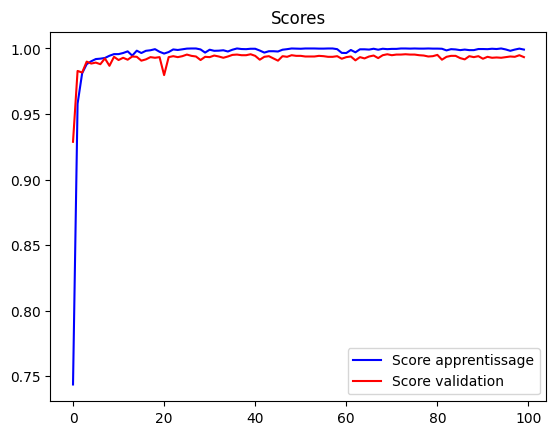

In [300]:
plot_scores(train)

In [301]:
model2 = tensorflow.keras.models.load_model('./weights/7b_addr_identification.h5')
    

r = [
    'piece 1 of 1',
    '34 rue de cherbourg',
    'weight (lb.) 99',
    '484121025410',
    '75541 Paris 13e rue des moustaches',
    'ship to/poe',
    '     weight (ib.) 99',
    '  cube (ft.) a',
    'tac/typeservice/carrier ups',
    'date shipped o-jan-17'
]

r_c, r_w = preprocessing(r)

model2.predict([r_c, r_w])

1/1 [==============================] - 0s 177ms/step


array([[1.52794860e-10, 1.33665318e-11, 2.13623132e-14, 1.00000000e+00],
       [1.00000000e+00, 1.05659598e-25, 1.04938242e-24, 1.26862983e-16],
       [1.99842495e-16, 4.09945004e-18, 1.52335589e-26, 1.00000000e+00],
       [6.22929469e-35, 1.00000000e+00, 4.94353784e-27, 1.78747219e-16],
       [9.99989986e-01, 8.56482474e-13, 7.90705235e-06, 2.06404729e-06],
       [3.65487622e-08, 8.26083044e-14, 1.81989268e-08, 1.00000000e+00],
       [6.54309289e-12, 1.14896065e-17, 3.20214974e-22, 1.00000000e+00],
       [5.97531488e-03, 4.90224805e-10, 8.94741970e-06, 9.94015694e-01],
       [7.35853405e-08, 3.16059163e-14, 3.00731351e-08, 9.99999881e-01],
       [4.62432826e-13, 2.10323919e-19, 6.55659905e-19, 1.00000000e+00]],
      dtype=float32)

In [302]:
r_w[-4]

array([1, 2, 1, 2, 1, 3, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [303]:
model2.save('weights/7b_addr_identification.h5')